In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

CHEN_DATA_DIRECTORY = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM'
CHEN_FILE_STEM = f'Supplementary_Data_2' # chen scores for 1kb windows

PUBLIC_REPO = 'constraint-tools-data'
PUBLIC_REPO_DIR = f'/scratch/ucgd/lustre-work/quinlan/u6018199/{PUBLIC_REPO}'

SUFFIXES = ['gnocchi', 'N_observed', 'K_bar', 'N_expected_gnocchi'] # K_bar >> 1 indicates negative selection 

## Compute observed SNV counts, expected counts under gnocchi, and Kbar for Chen's windows 

In [2]:
import pandas as pd
import numpy as np 

from tqdm import tqdm
tqdm.pandas()

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def get_gnocchi(): 
  filename = f'{CHEN_DATA_DIRECTORY}/{CHEN_FILE_STEM}.bed'  
  df = pd.read_csv(
    filename, 
    sep='\t',
    names=['chromosome', 'start', 'end', 'gnocchi']
  )
  return df 

def get_observed_counts_and_Kbar():
  filename = f'{CONSTRAINT_TOOLS_DATA}/genome-wide-predictions/predict-germline-grch38.chen-windows.bed'
  df = pd.read_csv(
    filename, 
    sep='\t',
  )
  df = df[['chromosome', 'start', 'end', 'N_observed', 'K_bar']]
  return df 

def compute_expected_count_under_gnocchi(row): 
  a = 1 
  b = -(2*row['N_observed'] + row['gnocchi']**2)
  c = row['N_observed']**2
  sqrt = np.sqrt(b**2 - 4*a*c) 
  sign = 1 if row['gnocchi'] > 0 else -1
  return (-b + sign*sqrt)/(2*a)
  
def wrangle_K_bar(df): 
  df['K_bar'] = pd.to_numeric(df['K_bar'], errors='coerce') # convert '.' to 'NaN'
  df = df.dropna(subset=['K_bar']) # drop windows for which K_bar == NaN
  # df['negative_K_bar'] = -df['K_bar']
  return df

def compute_expected_counts_under_gnocchi_and_Kbar(): 
  df = pd.merge(
    get_gnocchi(), 
    get_observed_counts_and_Kbar(), 
    how='inner', 
    on=['chromosome', 'start', 'end']
  )

  df = wrangle_K_bar(df)

  df['N_expected_gnocchi'] = df.progress_apply(compute_expected_count_under_gnocchi, axis=1) # type: ignore

  for col in SUFFIXES: 
    df[['chromosome', 'start', 'end', f'{col}']].to_csv(
      f'{CHEN_DATA_DIRECTORY}/{CHEN_FILE_STEM}-{col}.bed', 
      sep='\t', 
      index=False, 
      header=False
    )

  return df 

compute_expected_counts_under_gnocchi_and_Kbar()

100%|█████████████████████████████| 1794224/1794224 [00:30<00:00, 59745.84it/s]


,chromosome,start,end,gnocchi,N_observed,K_bar,N_expected_gnocchi
0,chr1,1432000,1433000,4.299894,259,-1.954207,338.059552
1,chr1,1435000,1436000,3.331645,273,1.006365,333.876799
2,chr1,1449000,1450000,1.817267,225,-0.402920,253.960193
3,chr1,1450000,1451000,1.365863,312,-3.416013,337.076763
4,chr1,1451000,1452000,0.666316,291,-1.317331,302.590657
...,...,...,...,...,...,...,...
1795651,chr9,137269000,137270000,5.276351,209,-0.785837,300.458958
1795652,chr9,137275000,137276000,2.687348,290,-2.409468,339.517045
1795653,chr9,137282000,137283000,-0.090791,210,-0.333503,208.688422
1795654,chr9,137290000,137291000,2.162811,223,-1.182283,257.721105


## Visualize these variables in UCSC genome browser 

In [3]:
from shell import shell 

def prepare_data_for_UCSC_genome_browser():
  prepare_data = f'{CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/prepare-data-for-UCSC-genome-browser.sh' 

  for suffix in tqdm(SUFFIXES): 
    data_directory = CHEN_DATA_DIRECTORY
    data_stem = f'{CHEN_FILE_STEM}-{suffix}'
    track_name = suffix
    track_description = suffix
    cmd = (
      f'bash '
      f'{prepare_data} '
      f'{data_directory} {data_stem} {PUBLIC_REPO_DIR} '
      f'{track_name} {track_description}'
    )
    print(shell(cmd))

prepare_data_for_UCSC_genome_browser()

 25%|███████████                                 | 1/4 [00:09<00:27,  9.13s/it]

Wrote: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-gnocchi.bedGraph
Everything up-to-date
Pushed Supplementary_Data_2-gnocchi.bedGraph to public repo
"Supplementary_Data_2-gnocchi.bedGraph" already supported
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


 50%|██████████████████████                      | 2/4 [00:16<00:16,  8.10s/it]

Wrote: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-N_observed.bedGraph
Everything up-to-date
Pushed Supplementary_Data_2-N_observed.bedGraph to public repo
"Supplementary_Data_2-N_observed.bedGraph" already supported
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


 75%|█████████████████████████████████           | 3/4 [00:27<00:09,  9.52s/it]

Wrote: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-K_bar.bedGraph
To https://github.com/petermchale/constraint-tools-data.git
   47ce2f6..26f4e5b  main -> main
Pushed Supplementary_Data_2-K_bar.bedGraph to public repo
"Supplementary_Data_2-K_bar.bedGraph" already supported
[main 26f4e5b] Add Supplementary_Data_2-K_bar in UCSC-genome-browser format (bedgraph)
 1 file changed, 2 insertions(+), 2 deletions(-)
Uploading LFS objects: 100% (1/1), 78 MB | 23 MB/s, done.


100%|████████████████████████████████████████████| 4/4 [00:35<00:00,  8.84s/it]

Wrote: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-N_expected_gnocchi.bedGraph
Everything up-to-date
Pushed Supplementary_Data_2-N_expected_gnocchi.bedGraph to public repo
"Supplementary_Data_2-N_expected_gnocchi.bedGraph" already supported
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [4]:
# TODO: a "track hub" might make more sense when there are multiple custom tracks 

def get_ucsc_genome_browser_link(chrom, start, end): 
  attribute_value_pair = f'position={chrom}%3A{start}-{end}'
  for suffix in SUFFIXES: 
    data_stem = f'{CHEN_FILE_STEM}-{suffix}'
    data_url = f'http://github.com/petermchale/constraint-tools-data/raw/main/{data_stem}.bedGraph'
    # https://genome-blog.gi.ucsc.edu/blog/2021/08/13/sharing-data-with-sessions-and-urls/  
    browser_url = f'https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&{attribute_value_pair}&hgct_customText={data_url}'
    print(f'UCSC genome browser: {browser_url}')

get_ucsc_genome_browser_link(chrom='chr4', start=1, end=190214555)

UCSC genome browser: https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&position=chr4%3A1-190214555&hgct_customText=http://github.com/petermchale/constraint-tools-data/raw/main/Supplementary_Data_2-gnocchi.bedGraph
UCSC genome browser: https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&position=chr4%3A1-190214555&hgct_customText=http://github.com/petermchale/constraint-tools-data/raw/main/Supplementary_Data_2-N_observed.bedGraph
UCSC genome browser: https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&position=chr4%3A1-190214555&hgct_customText=http://github.com/petermchale/constraint-tools-data/raw/main/Supplementary_Data_2-K_bar.bedGraph
UCSC genome browser: https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&position=chr4%3A1-190214555&hgct_customText=http://github.com/petermchale/constraint-tools-data/raw/main/Supplementary_Data_2-N_expected_gnocchi.bedGraph


## Plot smoothed Gnocchi 

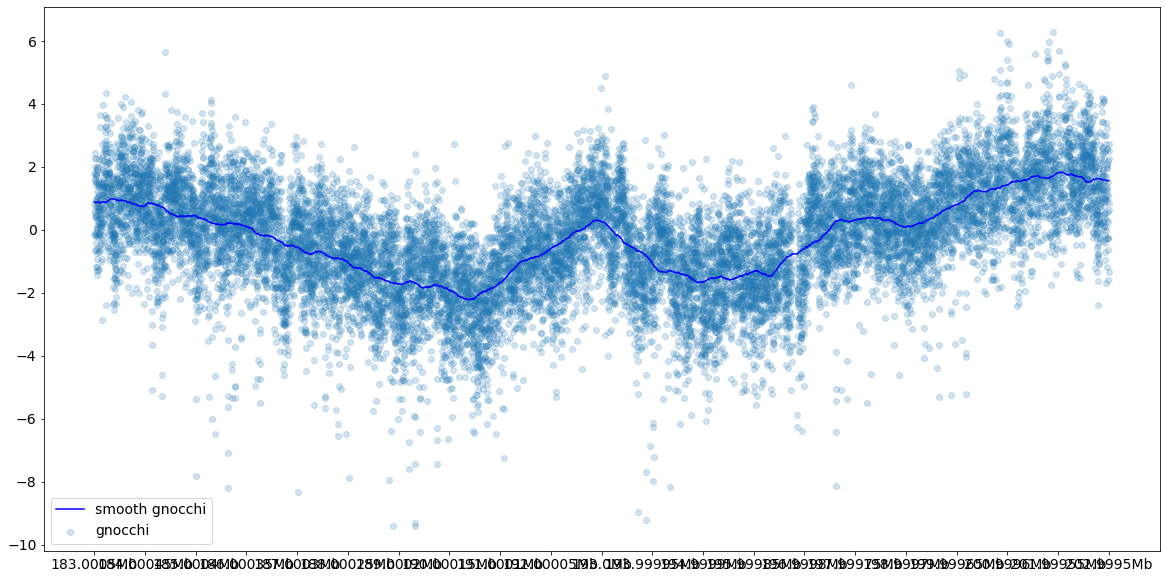

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.ndimage import uniform_filter1d

plt.rcParams['font.size'] = 14

def plot_smoothed_gnocchi(chromosome, start, end):
  df = get_gnocchi()

  df = df[df['chromosome'] == chromosome]

  df['center'] = (df['start'] + df['end'])/2
  df = df[
    (df['center'] > start) &
    (df['center'] < end)
  ]

  x = df['center']
  x = np.array(x)
  y = df['gnocchi']
  y = np.array(y)

  sort_indices = np.argsort(x)
  x = x[sort_indices]
  y = y[sort_indices]

  # Approach 1 (c.f., experiments/germline-model/chen-et-al-2022/deletion-density.1.ipynb)
  # 1. create a set of large windows 
  # 2. intersect large windows with small windows 
  # 3. group by large windows, computing the mean gnocchi within each group 
  # 4. write to bed
  # 5. convert bed to bedgraph and serve
  # 6. visualize as custom track in UCSC genome browser

  # TODO: check this 
  # Approach 2: replace each y-value by the mean of the `size` y-values in the neighborhood of the y-value
  y_smooth = uniform_filter1d(y, size=1000)

  plt.figure(figsize=(20, 10))
  plt.scatter(x, y, label='gnocchi', alpha=0.2)
  plt.plot(x, y_smooth, color='blue', label='smooth gnocchi')
  plt.legend()

  # Calculate the step size based on the range of x and the desired number of ticks
  step = (max(x) - min(x)) / 20
  plt.xticks(np.arange(min(x), max(x)+1, step))

  # TODO: check 
  # Format the x-ticks as "1Mb", "2Mb", etc.
  formatter = ticker.FuncFormatter(lambda x, pos: '{}Mb'.format(x/1e6))
  plt.gca().xaxis.set_major_formatter(formatter)

  plt.show()  

plot_smoothed_gnocchi(chromosome='chr1', start=183e6, end=203e6)